ref: https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torch.utils.data as data_utils

In [14]:
batch_size = 4
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose([
    transforms.Resize(32),       # 한 축을 128로 조절하고
    transforms.ToTensor(),        # Tensor로 바꾸고 (0~1로 자동으로 normalize)
])

train_data = datasets.ImageFolder(root="images/", transform=transform)

test_len = int(len(train_data) * 0.2)
train_data, test_data = data_utils.random_split(train_data, (len(train_data) - valid_len, valid_len))

trainloader = data_utils.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = data_utils.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

print('===== trainloader sample')
for i, data in enumerate(trainloader):
    print('input image: {}'.format(data[0].size()))  # input image
    print('class label: {}'.format(data[1]))         # class label
    break

print('===== testloader sample')
for i, data in enumerate(testloader):
    print('input image: {}'.format(data[0].size()))  # input image
    print('class label: {}'.format(data[1]))         # class label
    break
    
classes = ('10_20', '11_14', '13_1', '13_15', '13_16', '13_17', '13_18', '13_20', '13_6', '13_9', '3_20', '3_5', '4_11', '4_2', '4_7', '5_8', '7_1', '7_20', '8_6', '8_9')

===== trainloader sample
input image: torch.Size([4, 3, 32, 32])
class label: tensor([ 3,  9,  4, 12])
===== testloader sample
input image: torch.Size([4, 3, 32, 32])
class label: tensor([ 1,  7,  5, 11])


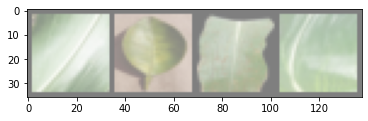

 3_20   5_8   3_5  3_20


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [19]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [26]:
log_interval = 200
no_cuda = True
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

def test(log_interval, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
                    test_loss = criterion(outputs, labels)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format
          (test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [28]:
for epoch in range(10):   # 데이터셋을 수차례 반복합니다.

    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(trainloader, 0):
        
            # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
            inputs, labels = data

            # 순전파 + 역전파 + 최적화를 한 후
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            # 통계를 출력합니다.
            test_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, test_loss / 2000))
                test_loss = 0.0            
            
print('Finished Training')

[1,  2000] loss: 0.848

Test set: Average loss: -7.7184, Accuracy: 2324/3200 (73%)

[2,  2000] loss: 0.732

Test set: Average loss: -9.0992, Accuracy: 2222/3200 (69%)

[3,  2000] loss: 0.677

Test set: Average loss: -9.4084, Accuracy: 2394/3200 (75%)

[4,  2000] loss: 0.615

Test set: Average loss: -10.3223, Accuracy: 2409/3200 (75%)

[5,  2000] loss: 0.558

Test set: Average loss: -11.2698, Accuracy: 2355/3200 (74%)

[6,  2000] loss: 0.546

Test set: Average loss: -11.7312, Accuracy: 2510/3200 (78%)

[7,  2000] loss: 0.475

Test set: Average loss: -12.3099, Accuracy: 2401/3200 (75%)

[8,  2000] loss: 0.446

Test set: Average loss: -11.5823, Accuracy: 2520/3200 (79%)

[9,  2000] loss: 0.426

Test set: Average loss: -12.2918, Accuracy: 2515/3200 (79%)

[10,  2000] loss: 0.392

Test set: Average loss: -13.2699, Accuracy: 2527/3200 (79%)

Finished Training


In [8]:
PATH = './disease_net.pth'
torch.save(net.state_dict(), PATH)